# Réalisez un traitement dans un environnement Big Data sur le Cloud

# ________________________________________________________________

## SOMMAIRE

### [**DEPLOIEMENT DE LA SOLUTION DANS LE CLOUD**](#**DEPLOIEMENT-DE-LA-SOLUTION-DANS-LE-CLOUD**)
- [1. Importation des Bibliothèques](#Importation-des-Bibliothèques)
- [2. Définition des chemins de données pour les images (PATH_Data) et pour stocker les résultats (PATH_Result)](#Définition-des-chemins-de-données)
- [3. Traitement des données](#Traitement-des-données)
- [4. Préparation du modèle MobileNetV2](#Préparation-du-modèle-MobileNetV2)
- [5. Broadcast des poids du modèle](#Broadcast-des-poids-du-modèle)
- [6. Mettons cela sous forme de fonction](#Mettons-cela-sous-forme-de-fonction)
- [7. Définition des fonctions de Prétraitement des images et d'Application de leur featurisation à travers l'utilisation de pandas UDF et de la réduction des dimensions PCA](#Prétraitement-des-images-et-application-de-leur-featurisation)
- [8. Exécution des actions d'extraction de features](#Exécution-des-actions-d'extraction-de-features)
- [9. conversion des résultats de la PCA (les vecteurs réduits) en liste Python](#conversion-des-résultats-de-la-PCA-(les-vecteurs-réduits)-en-liste-Python)
- [10. Chargement en pandas + export CSV](#Chargement-en-pandas-+-export-CSV)

# ________________________________________________________________

# **DEPLOIEMENT DE LA SOLUTION DANS LE CLOUD** <a id="**DEPLOIEMENT-DE-LA-SOLUTION-DANS-LE-CLOUD**"></a>

### **1. Importation des Bibliothèques** <a id="Importation-des-Bibliothèques"></a>
* Import des modules nécessaires pour la manipulation des données, le traitement des images et la construction du modèle de réseau de neurones.

In [1]:
!pip install --upgrade numpy pandas matplotlib seaborn pillow tensorflow pyspark

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: astor file-astor-VERSION has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of astor or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [2]:
import pandas as pd
from PIL import Image
import numpy as np
import io
import shutil
import os
import random

import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from pyspark.ml.feature import VectorAssembler
from tensorflow.keras import Model
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, element_at, split
from pyspark.sql import SparkSession

from pyspark.sql.functions import expr
from pyspark.sql.functions import udf
from pyspark.ml.feature import PCA, StandardScaler
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.types import ArrayType, FloatType

import matplotlib.pyplot as plt
import matplotlib as matplotlib
import matplotlib as mpl
import seaborn as sns
from pyspark.sql.types import ArrayType, FloatType, DoubleType

import tensorflow as tf
tf.get_logger().setLevel('ERROR')

***

In [3]:
print(f"Pandas version: {pd.__version__}")
print(f"Numpy version: {np.__version__}")
print(f"TensorFlow version: {tf.__version__}")
print(f"Matplotlib version: {mpl.__version__}")
print(f"Seaborn version: {sns.__version__}")

Pandas version: 1.3.5
Numpy version: 1.21.6
TensorFlow version: 2.4.1
Matplotlib version: 3.5.3
Seaborn version: 0.12.2


***

### **2. Définition des chemins de données pour les images (PATH_Data) et pour stocker les résultats (PATH_Result)** <a id="Définition-des-chemins-de-données"></a>

In [4]:
PATH = "s3a://p9-data-mk-opc/matym/"
PATH_Data = PATH + 'Test'
PATH_Result = PATH + 'Results'

print('PATH:        ' + PATH +
      '\nPATH_Data:   ' + PATH_Data +
      '\nPATH_Result: ' + PATH_Result)


PATH:        s3a://p9-data-mk-opc/matym/
PATH_Data:   s3a://p9-data-mk-opc/matym/Test
PATH_Result: s3a://p9-data-mk-opc/matym/Results


***

### **8. Création de la session Spark** <a id="Création-de-la-session-Spark"></a>
L’application Spark est contrôlée grâce à un processus de pilotage (driver process) appelé **SparkSession**.

Une instance de **SparkSession** est la façon dont Spark exécute les fonctions définies par l’utilisateur dans l’ensemble du cluster. Une SparkSession correspond toujours à une application Spark.

Ici nous créons une session spark en spécifiant dans l'ordre :
* un **nom pour l'application**, qui sera affichée dans l'interface utilisateur Web Spark "**FruitClassifierS3**"
* que l'application doit s'exécuter **localement**. Nous ne définissons pas le nombre de cœurs à utiliser (comme .master('local[4]) pour 4 cœurs à utiliser), nous utiliserons donc tous les cœurs disponibles dans notre processeur.
* une option de configuration supplémentaire permettant d'utiliser le **format "parquet"** que nous utiliserons pour enregistrer et charger le résultat de notre travail. Le paramètre writeLegacyFormat assure la compatibilité avec les anciennes versions de Parquet.
* vouloir **obtenir une session spark** existante ou si aucune n'existe, en créer une nouvelle.
* Nous créons également la variable "sc" qui est un SparkContext issue de la variable spark, pour diffuser les poids du modèle plus tard

In [6]:
spark = SparkSession.builder \
    .appName("FruitClassifierS3") \
    .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
    .config("spark.hadoop.fs.s3a.aws.credentials.provider",
            "com.amazonaws.auth.InstanceProfileCredentialsProvider,com.amazonaws.auth.DefaultAWSCredentialsProviderChain") \
    .config("spark.sql.parquet.output.committer.class", "org.apache.parquet.hadoop.ParquetOutputCommitter") \
    .config("mapreduce.fileoutputcommitter.algorithm.version", "1") \
    .config("spark.jars", "/usr/lib/hadoop/hadoop-aws-3.2.1-amzn-3.jar,"
                          "/usr/lib/zeppelin/plugins/NotebookRepo/S3NotebookRepo/aws-java-sdk-core-1.11.977.jar,"
                          "/usr/lib/zeppelin/plugins/NotebookRepo/S3NotebookRepo/aws-java-sdk-s3-1.11.977.jar,"
                          "/usr/lib/zeppelin/plugins/NotebookRepo/S3NotebookRepo/aws-java-sdk-kms-1.11.977.jar,"
                          "/usr/lib/zeppelin/plugins/NotebookRepo/S3NotebookRepo/aws-java-sdk-dynamodb-1.11.977.jar") \
    .getOrCreate()

In [7]:
sc = spark.sparkContext

spark  # Vérifie que la session Spark est bien active

# pour réduire les logs verbeux
spark.sparkContext.setLogLevel("ERROR")

***

### **3. Traitement des données** <a id="Traitement-des-données"></a>
Dans la suite de notre flux de travail, nous allons successivement :
* Préparer nos données
    * Importer les images dans un dataframe pandas UDF
    * Associer aux images leur label
    * Préprocesser en redimensionnant nos images pour qu'elles soient compatibles avec notre modèle
* Préparer notre modèle
    * Importer le modèle MobileNetV2
    * Créer un nouveau modèle dépourvu de la dernière couche de MobileNetV2
* Définir le processus de chargement des images et l'application de leur featurisation à travers l'utilisation de pandas UDF
* Exécuter les actions d'extraction de features
* Enregistrer le résultat de nos actions
* Tester le bon fonctionnement en chargeant les données enregistrées

* #### a) **Chargement des images** <a id="Chargement-des-images"></a>
* Les images sont chargées en tant que **fichiers binaires** dans un DataFrame Spark, ce qui offre, plus de souplesse dans la façon de prétraiter les images.
* Avant de charger les images, nous spécifions que nous voulons charger uniquement les fichiers dont l'extension est **jpg**.
* Nous indiquons également de charger tous les objets possibles contenus dans les sous-dossiers du dossier communiqué. `recursiveFileLookup` permet de parcourir les sous-dossiers.

In [8]:
images = spark.read.format("binaryFile") \
  .option("pathGlobFilter", "*.jpg") \
  .option("recursiveFileLookup", "true") \
  .load(PATH_Data)

# Compter le nombre d'images chargées
nombre_images = images.count()

# Afficher le résultat
print(f"Nombre d'images chargees : {nombre_images}")

Nombre d'images chargees : 22688


* #### b) **Extraction des labels** <a id="Extraction-des-labels"></a>
Affichage des 5 premières images contenant :
* le path de l'image
* la date et heure de sa dernière modification
* sa longueur
* son contenu encodé en valeur hexadécimal

Nous ne conservons que le path de l'image et ajoutons une colonne contenant les labels de chaque image; Les labels sont les sous-dossiers contenant les images, récupérés avec split.

In [9]:
# Extraction du label à partir du chemin des fichiers en prenant l'avant-dernier élément du chemin
images = images.withColumn('label', element_at(split(images['path'], '/'),-2))
print(images.printSchema())
images.select("path", "label").show(10, truncate=False)

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- label: string (nullable = true)

None
+--------------------------------------------------------+----------+
|path                                                    |label     |
+--------------------------------------------------------+----------+
|s3a://p9-data-mk-opc/matym/Test/Watermelon/r_106_100.jpg|Watermelon|
|s3a://p9-data-mk-opc/matym/Test/Watermelon/r_109_100.jpg|Watermelon|
|s3a://p9-data-mk-opc/matym/Test/Watermelon/r_108_100.jpg|Watermelon|
|s3a://p9-data-mk-opc/matym/Test/Watermelon/r_107_100.jpg|Watermelon|
|s3a://p9-data-mk-opc/matym/Test/Watermelon/r_95_100.jpg |Watermelon|
|s3a://p9-data-mk-opc/matym/Test/Watermelon/r_79_100.jpg |Watermelon|
|s3a://p9-data-mk-opc/matym/Test/Watermelon/r_84_100.jpg |Watermelon|
|s3a://p9-data-mk-opc/matym/Test/Watermelon/r_94_100.jpg |Watermelon|
|s3a://p9-data-mk-op

***

### **4. Préparation du modèle MobileNetV2** <a id="Préparation-du-modèle-MobileNetV2"></a>
Je vais utiliser la technique du **transfert learning** pour extraire les features des images.
J'ai choisi d'utiliser le modèle **MobileNetV2** pour sa rapidité d'exécution comparée à d'autres modèles comme **VGG16** par exemple. La dernière couche dense (output) est retirée pour obtenir des embeddings (vecteurs de caractéristiques).

Pour en savoir plus sur la conception et le fonctionnement de MobileNetV2, je vous invite à lire [cet article](https://towardsdatascience.com/review-mobilenetv2-light-weight-model-image-classification-8febb490e61c).

Voici le schéma de son architecture globale :

![Architecture de MobileNetV2](img/mobilenetv2_architecture.png)

Il existe une dernière couche qui sert à classer les images selon 1000 catégories que nous ne voulons pas utiliser.
L'idée dans ce projet est de récupérer le **vecteur de caractéristiques de dimensions (1,1,1280)** qui servira, plus tard, au travers d'un moteur de classification à reconnaitre les différents fruits du jeu de données.

Comme d'autres modèles similaires, **MobileNetV2**, lorsqu'on l'utilise en incluant toutes ses couches, attend obligatoirement des images de dimension (224,224,3). Nos images étant toutes de dimension (100,100,3), nous devrons simplement les **redimensionner** avant de les confier au modèle.

Dans l'odre :
* Nous chargeons le modèle **MobileNetV2** avec les poids **précalculés** issus d'**imagenet** et en spécifiant le format de nos images en entrée
* Nous créons un nouveau modèle avec :
    * en entrée : l'entrée du modèle MobileNetV2
    * sortie : l'avant dernière couche du modèle MobileNetV2

In [10]:
model = MobileNetV2(weights='imagenet',
                    include_top=True,
                    input_shape=(224, 224, 3))

new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)

# Affichage du résumé de notre nouveau modèle où nous constatons que nous récupérons bien en sortie un vecteur de dimension (1, 1, 1280)
new_model.summary()

2025-06-26 22:43:44.592697: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

***

### **5. Broadcast des poids du modèle** <a id="Broadcast-des-poids-du-modèle"></a>
* Les poids du modèle sont diffusés (broadcast) pour être utilisés sur tous les nœuds du cluster *(Tous les workeurs doivent pouvoir accéder au modèle ainsi qu'à ses poids. Une bonne pratique consiste à charger le modèle sur le driver puis à diffuser ensuite les poids aux différents workeurs).*
* Réduction du temps de transfert des poids lors du calcul distribué.

In [11]:
brodcast_weights = sc.broadcast(new_model.get_weights())

***

### **6. Mettons cela sous forme de fonction** <a id="Mettons-cela-sous-forme-de-fonction"></a>
* Fonction pour créer un modèle avec les poids diffusés (broadcast), évitant ainsi de charger les poids sur chaque exécution.

In [12]:
def model_fn():
    model = MobileNetV2(weights='imagenet',
                        include_top=True,
                        input_shape=(224, 224, 3))
    for layer in model.layers:
        layer.trainable = False
    new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)
    new_model.set_weights(brodcast_weights.value)
    return new_model

***

### **7. Définition des fonctions de Prétraitement des images et d'Application de leur featurisation à travers l'utilisation de pandas UDF et de la réduction des dimensions PCA** <a id="Prétraitement-des-images-et-application-de-leur-featurisation"></a>

* #### a) **Prétraitement des images** <a id="Prétraitement des images"></a>
Convertit les images en tableaux normalisés pour MobileNetV2.

In [13]:
def preprocess(content):
    """
    Prétraite les données d'images brutes pour la prédiction.
    Redimensionne l'image à 224x224 et la convertit en tableau prêt à être utilisé par MobileNetV2.
    """
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)
    return preprocess_input(arr)

* #### b) **Extraction des vecteurs de caractéristiques (features) à partir d’une série de contenu** <a id="   "></a>
* Transforme une série content_series en une série de vecteurs de caractéristiques (vecteurs d’images extraits par notre CNN "MobileNetV2").

In [14]:
def featurize_series(model, content_series, batch_size=100):
    """
    Extrait des caractéristiques d'une série d'images brutes avec le modèle fourni.
    Traite les images par batchs pour éviter de saturer la mémoire.
    Retourne une pd.Series des caractéristiques aplaties des images pour un stockage simplifié.
    """
    features = []
    n = len(content_series)

    for i in range(0, n, batch_size):
        batch_series = content_series.iloc[i:i+batch_size]
        batch_input = np.stack(batch_series.map(preprocess))
        batch_preds = model.predict(batch_input)
        batch_output = [p.flatten() for p in batch_preds] # Aplatissement des tenseurs pour faciliter le stockage
        features.extend(batch_output)

    return pd.Series(features)

* #### c) **Featurisation** <a id="Featurisation"></a>
* Utilisation d'un UDF Spark pour vectoriser les images par batch (méthode SCALAR_ITER), accélérant le traitement distribué.

In [16]:
@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    '''
    UDF Pandas Scalar Iterator pour la featurisation d'images.
    Retourne une colonne Spark de type Array<Float> représentant les caractéristiques des images.
    Le modèle est chargé une fois et utilisé pour plusieurs lots de données pour optimiser les performances.
    '''
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

* #### d) **Fonction d'Exploration statistique des features** <a id="Fonction-d'Exploration-statistique-des-features"></a>
Nous allons faire un diagnostic exploratoire statistique des features avant PCA.
    
`def explore_features_stats(df)`

* On utilise `posexplode(features)` pour transformer chaque ligne de features (vecteur) en colonnes i (indice) et value (valeur).
* On explose le vecteur features en 1280 colonnes (feature_0 à feature_1279) pour :
    * Calculer moyenne et écart-type de chaque feature,
    * Visualiser leur distribution (histogrammes des moyennes et des écarts-types des features avec sns.histplot),
    * Vérifier si la normalisation est justifiée ou si certaines features ont peu de variance (=> candidates à retrait).

In [17]:
plt.style.use('seaborn-whitegrid')

def explore_features_stats(df):
    df_exploded = df.selectExpr("posexplode(features) as (i, value)")
    stats = df_exploded.groupBy("i").agg(
        expr("mean(value)").alias("mean_i"),
        expr("stddev(value)").alias("stddev_i")
    ).orderBy("i")

    # Collecte des données en mémoire
    stats_local = stats.collect()
    stats_pd = pd.DataFrame([row.asDict() for row in stats_local])

    # Tracé avec seaborn
    plt.figure(figsize=(14, 6))

    # Moyennes
    plt.subplot(1, 2, 1)
    sns.histplot(stats_pd["mean_i"], bins=50, color='steelblue', kde=True, edgecolor='black', alpha=0.8)
    plt.axvline(0, color='red', linestyle='--', linewidth=1.5, label='Référence')
    plt.title("Distribution des moyennes des features", fontsize=14, weight='bold')
    plt.xlabel("Moyenne", fontsize=12)
    plt.ylabel("Fréquence", fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    # Écarts-types
    plt.subplot(1, 2, 2)
    sns.histplot(stats_pd["stddev_i"], bins=50, color='seagreen', kde=True, edgecolor='black', alpha=0.8)
    plt.axvline(1, color='red', linestyle='--', linewidth=1.5, label='Référence')
    plt.title("Distribution des écarts-types des features", fontsize=14, weight='bold')
    plt.xlabel("Écart-type", fontsize=12)
    plt.ylabel("Fréquence", fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

* #### e) **Fonction de Prétraitement pour PCA** <a id="Prétraitement-pour-PCA"></a>

  `def preprocess_for_pca(df)`

* Conversion des vecteurs en format dense pour PCA (Cela transforme chaque ligne de type liste ou SparseVector en un DenseVector, requis par la PCA de Spark).
* Standardisation des features pour garantir des résultats cohérents en PCA.
    
* On Utilise une UDF pour convertir chaque liste de features en un vecteur dense Spark MLlib (Vectors.dense()).
* On Applique une StandardScaler (centrage et réduction) :
    * withStd=True: divise par l'écart-type (σ),
    * withMean=True: centre les données.
    * Résultat : Ajout d'une nouvelle colonne features_scaled, prête pour PCA.

In [18]:
def preprocess_for_pca(df):
    to_dense = udf(lambda r: Vectors.dense(r), VectorUDT())
    df = df.withColumn('features_vector', to_dense('features'))

    scaler = StandardScaler(
        inputCol="features_vector",
        outputCol="features_scaled",
        withStd=True, withMean=True
    )
    scaler_model = scaler.fit(df)
    df_scaled = scaler_model.transform(df)
    
    # Mise en cache
    df_scaled = df_scaled.cache()
    df_scaled.count()  # Action pour forcer la mise en cache

    return df_scaled

* #### f) **Fonction pour afficher variance expliquée cumulée par les composantes principales du PCA et choisir k** <a id="Fonction-pour-afficher-variance-expliquée"></a>




Nous allons rendre rend le choix de k interprétable visuellement, au lieu d'appeller une fonction nb_composante() qui renvoie directement le k pour 95% de variance, sans visualisation ni contrôle.

`def plot_variance_and_select_k(df_scaled, max_k=100, seuils=[0.8, 0.95, 0.99])`

* On applique un PCA avec k=max_k composantes (par défaut : 100).
* On Calcule k optimal pour 80%, 95%, 99% de variance,
* On trace un graphique :
    * courbe de variance cumulée,
    * lignes verticales pour les seuils choisis (80%, 95%, 99%...),
    * indique le k optimal pour chaque seuil.

Objectif :
Trouver le nombre minimal de composantes à conserver pour garder une certaine proportion de l'information (ex : 95%).

In [19]:
def plot_variance_and_select_k(df_scaled, max_k=1280, seuils=[0.8, 0.95, 0.99]):

    pca = PCA(k=max_k, inputCol="features_scaled", outputCol="features_pca")
    model_pca = pca.fit(df_scaled)
    variance_ratio = model_pca.explainedVariance.toArray()
    cumulative = np.cumsum(variance_ratio)

    # Couleurs par seuil
    couleurs = {
        0.80: 'red',
        0.95: 'green',
        0.99: 'blue'
    }

    # Tracé
    plt.figure(figsize=(10, 6))

    ks = {}
    for s in seuils:
        k = int(np.argmax(cumulative >= s)) + 1
        ks[s] = k

        plt.axhline(y=s, color=couleurs.get(s, 'gray'), linestyle='--', alpha=0.5)
        plt.axvline(x=k-1, color=couleurs.get(s, 'gray'), linestyle='--', alpha=0.5)
        plt.scatter(k-1, cumulative[k-1], color=couleurs.get(s, 'gray'), s=80, label=f"{int(s*100)}% à k={k}")
        plt.text(k, cumulative[k-1] + 0.01, f"{int(s*100)}% à k={k}", fontsize=9, color=couleurs.get(s, 'gray'))

    plt.plot(cumulative, label="Variance cumulée", marker='o')
    plt.xlabel("Nombre de composantes")
    plt.ylabel("Variance cumulée")
    plt.title("Variance expliquée cumulée par PCA")
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

    # Affichage console
    for s, k in ks.items():
        print(f"[INFO] Nombre de composantes pour {int(s*100)}% de la variance : k = {k}")

    # Par défaut, renvoyer k pour le seuil 0.95 si présent sinon premier seuil
    k_optimal = ks.get(0.95, list(ks.values())[0])
    return k_optimal, model_pca, ks

* #### g) **Fonction pour appliquer le PCA Spark avec le k choisi** <a id="Fonction-pour-appliquer-le-PCA-Spark-avec-le-k-choisi"></a>
    `def apply_pca(df_scaled, k)`

* On applique la réduction de dimensionnalité PCA avec le nombre de composantes k.
    * On entraîne un modèle PCA avec k composantes.
    * On applique ce modèle pour transformer les données.
    * cela produit une nouvelle colonne : features_pca (vecteur réduit de taille k)

In [20]:
def apply_pca(df_scaled, k):
    pca = PCA(k=k, inputCol="features_scaled", outputCol="features_pca")
    model_pca = pca.fit(df_scaled)
    df_reduced = model_pca.transform(df_scaled)
    return df_reduced

# On prend en entrée df_scaled (le DataFrame déjà standardisé),
# On applique la PCA et on renvoie le DataFrame transformé df_reduced (qui contient la colonne "features_pca" avec les composantes principales)

***

### **8. Exécution des actions d'extraction de features** <a id="Exécution-des-actions-d'extraction-de-features"></a>
* Les Pandas UDF, sur de grands enregistrements (par exemple, de très grandes images), peuvent rencontrer des erreurs de type Out Of Memory (OOM).
* Si nous rencontrons de telles erreurs dans la cellule ci-dessous, nous essayerons de réduire la taille du lot Arrow via 'maxRecordsPerBatch'
* Je n'utiliserai pas cette commande dans ce projet et je laisse donc la commande en commentaire.

In [21]:
#spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "1024")

* #### a) **Extraction des features** <a id="Extraction-des-features"></a>
* Nous pouvons maintenant exécuter la featurisation sur l'ensemble de notre DataFrame Spark.

<u>REMARQUE</u> : Cela peut prendre beaucoup de temps, tout dépend du volume de données à traiter.

In [22]:
# Application du modèle sur les images
#Repartit les données d'images en 100 partitions, puis sélectionne les colonnes 'path', 'label' et les caractéristiques extraites ('features') via l'UDF de featurisation
features_df = images.repartition(100).select(col("path"),
                                            col("label"),
                                            featurize_udf("content").alias("features")
                                           )

In [23]:
features_df.printSchema()

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = true)



* #### c) **Sauvegarde des features brutes pour archive ou traçabilité (facultatif)** <a id="Sauvegarde-des-features-brutes-pour-archive-ou-traçabilité"></a>

In [22]:
#features_df.write.mode("overwrite").parquet(PATH_Result)

* #### d) **Pipeline complet de réduction de dimension par ACP** <a id="Pipeline-complet-de-réduction-de-dimension-par-ACP"></a>

Ce pipeline couvre l’exploration des caractéristiques, la normalisation, la sélection du nombre optimal de composantes principales selon la variance expliquée, l’application de l’ACP et la sauvegarde des résultats.

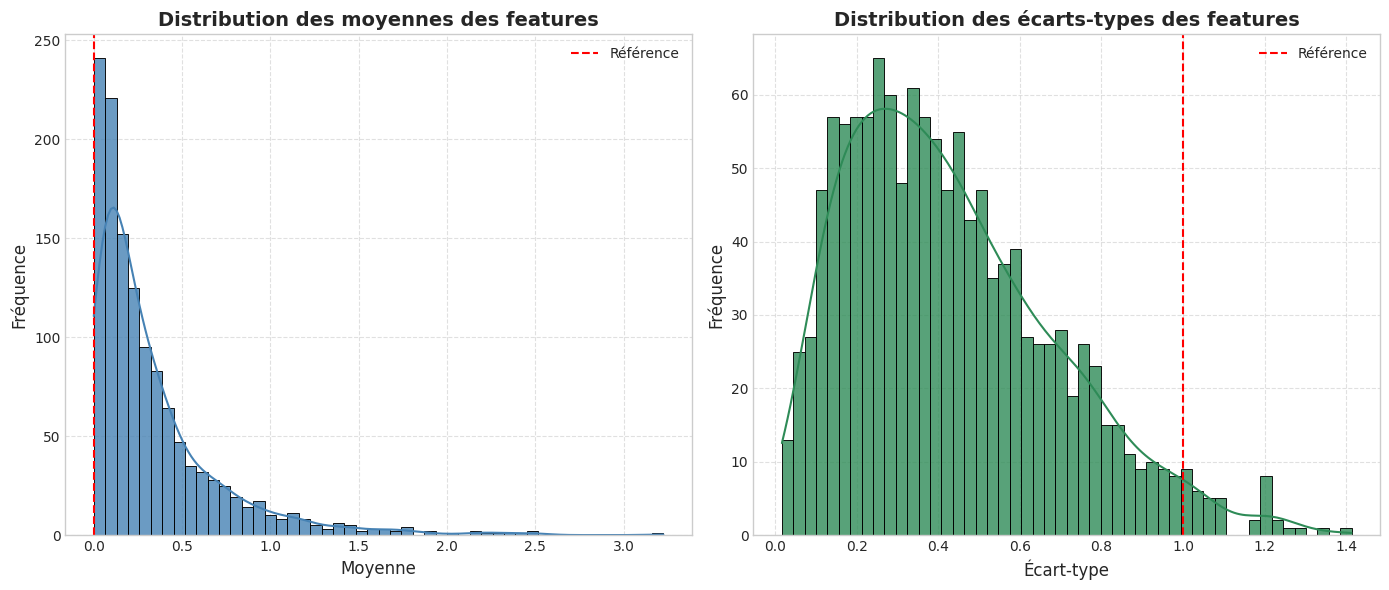

In [24]:
# 1. Exploration statistique des features
explore_features_stats(features_df)

In [24]:
# 2. Prétraitement : vecteur dense + standardisation
df_scaled = preprocess_for_pca(features_df)

2025-06-26 22:46:33.948707: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2025-06-26 22:46:33.949923: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2025-06-26 22:46:33.966437: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2025-06-26 22:46:34.018316: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2025-06-26 22:46:34.046303: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for bes

2025-06-26 22:55:31.506791: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2025-06-26 22:55:31.522858: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2025-06-26 22:55:33.378394: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2025-06-26 22:55:33.398707: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2499995000 Hz
2025-06-26 22:55:33.458704: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2025-06-26 22:55:33.459334: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2499995000 Hz
2025-06-26 22:55:33.482181: I tensorflow/compiler/

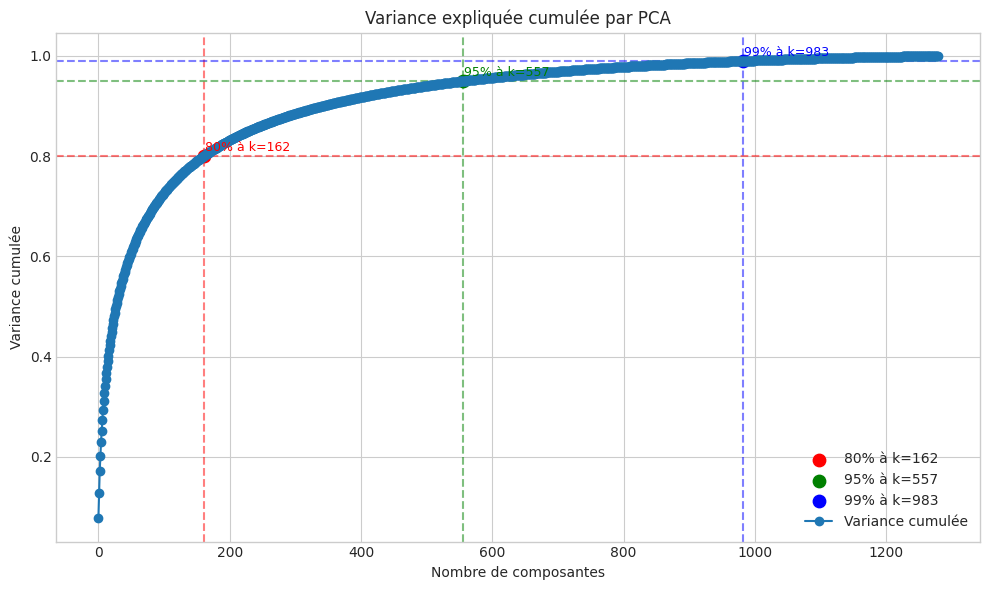

[INFO] Nombre de composantes pour 80% de la variance : k = 162
[INFO] Nombre de composantes pour 95% de la variance : k = 557
[INFO] Nombre de composantes pour 99% de la variance : k = 983
Dictionnaire des ks par seuil: {0.8: 162, 0.95: 557, 0.99: 983}


In [25]:
# 3. Choix du nombre de composantes k selon plusieurs seuils
#On va Choisir un seuil de variance (pas un k), puis calculer automatiquement le k minimal qui permet de l’atteindre.
k_optimal, model_pca, ks_dict = plot_variance_and_select_k(df_scaled, max_k=1280)
# ks_dict (on choisira le seuil qu'on veut dans ks_dict pour appliquer la PCA)
print("Dictionnaire des ks par seuil:", ks_dict)

In [26]:
# 4. Application de la PCA avec k composantes
df_reduit = apply_pca(df_scaled, k_optimal) # df_reduit contient le DataFrame final, avec les features réduites.

In [27]:
print(df_reduit)

DataFrame[path: string, label: string, features: array<float>, features_vector: vector, features_scaled: vector, features_pca: vector]


In [28]:
df_reduit.printSchema()

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- features_vector: vector (nullable = true)
 |-- features_scaled: vector (nullable = true)
 |-- features_pca: vector (nullable = true)



In [29]:
df_reduit.columns
df_reduit.show()

+--------------------+--------------+--------------------+--------------------+--------------------+--------------------+
|                path|         label|            features|     features_vector|     features_scaled|        features_pca|
+--------------------+--------------+--------------------+--------------------+--------------------+--------------------+
|s3a://p9-data-mk-...|    Watermelon|[0.0, 0.38355526,...|[0.0,0.3835552632...|[-0.7574006047611...|[-5.8525334981579...|
|s3a://p9-data-mk-...|     Raspberry|[0.5930733, 0.467...|[0.59307330846786...|[0.34159224421362...|[-1.9345406760531...|
|s3a://p9-data-mk-...|   Cauliflower|[0.054416295, 0.1...|[0.05441629514098...|[-0.6565646400098...|[-18.583042292541...|
|s3a://p9-data-mk-...|   Cauliflower|[0.0, 1.6184893, ...|[0.0,1.6184892654...|[-0.7574006047611...|[-6.0625332875521...|
|s3a://p9-data-mk-...|   Cauliflower|[0.0, 0.31852725,...|[0.0,0.3185272514...|[-0.7574006047611...|[-11.310568620206...|
|s3a://p9-data-mk-...|  

***

### **9. conversion des résultats de la PCA (les vecteurs réduits) en liste Python** <a id="conversion-des-résultats-de-la-PCA-(les-vecteurs-réduits)-en-liste-Python"></a>
Nous avions converti les features initiales en vecteurs denses (pour Spark), avec la fonction `def preprocess_for_pcadef preprocess_for_pca`.

Maintenant nous voulons sauvegarder au format CSV ou manipuler dans Pandas. Nous allons donc convertir les DenseVector finalement sortis de la PCA en Array[Float] ou list, via un udf(lambda v: v.toArray().tolist())

In [30]:
# Convertir les DenseVector en tableau Python
vector_to_array_udf = udf(lambda v: v.toArray().tolist(), ArrayType(DoubleType()))

# Créer un nouveau DataFrame avec des arrays
df_reduit_array = df_reduit.withColumn("features_pca_array", vector_to_array_udf("features_pca"))

# Sauvegarde uniquement les colonnes utiles
df_reduit_array.select("path", "label", "features_pca_array") \
    .write.mode("overwrite") \
    .parquet("/tmp/pca_results")

In [31]:
print(PATH_Result)

s3a://p9-data-mk-opc/matym/Results


***

### **10. Chargement en pandas + export CSV** <a id="Chargement-en-pandas-+-export-CSV"></a>

In [32]:
# Lecture en pandas
df = pd.read_parquet("s3://p9-data-mk-opc/matym/Results/pca_results", engine="pyarrow")

In [33]:
# Affichage des 5 première lignes du df
df.head()

,path,label,features_pca_array
0,s3a://p9-data-mk-opc/matym/Test/Watermelon/138...,Watermelon,"[-5.852533498157974, 7.71985113475199, -4.8392..."
1,s3a://p9-data-mk-opc/matym/Test/Raspberry/206_...,Raspberry,"[-1.9345406760531845, 0.9704594268845921, 1.92..."
2,s3a://p9-data-mk-opc/matym/Test/Cauliflower/r_...,Cauliflower,"[-18.583042292541975, 1.5102423173678368, 3.86..."
3,s3a://p9-data-mk-opc/matym/Test/Cauliflower/r2...,Cauliflower,"[-6.062533287552105, 5.983153144510915, -0.466..."
4,s3a://p9-data-mk-opc/matym/Test/Cauliflower/r_...,Cauliflower,"[-11.31056862020602, 2.650441964949531, 1.4431..."


In [37]:
# Vérification
print("Shape d'un vecteur PCA :", np.array(df.loc[0, 'features_pca_array']).shape)

Shape d'un vecteur PCA : (557,)


Nous retrouvons bien nos 557 composantes.

In [39]:
# Export CSV
df.to_csv("P9-df_features_pca_array.csv", index=False)

In [41]:
df.to_csv(r"C:\Users\matym\Desktop\FORMATION\PROJET 9\Projet à faire\data\Results\P9-df_features_pca_array.csv", index=False)

In [40]:
!aws s3 cp ./Notebook_Cloud.ipynb s3://p9-data-mk-opc/matym/

upload: ./Notebook_Cloud.ipynb to s3://p9-data-mk-opc/matym/Notebook_Cloud.ipynb


***